In [2]:
## importing the required packages
import pandas
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import scanpy as sc
import scikitplot as skplt # for roc curve 

In [2]:
input_file_name = 'linfeidat.csv'
results_file = './write/lindat.h5ad'  # the file that will store the analysis results

In [7]:
adata = sc.read_csv(input_file_name)
adata = sc.AnnData.transpose(adata)
adata

AnnData object with n_obs × n_vars = 16383 × 19 

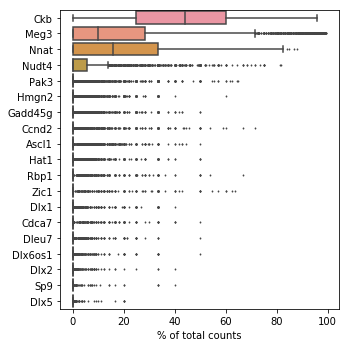

AnnData object with n_obs × n_vars = 4986 × 19 
    obs: 'n_genes', 'n_counts'
    obsm: 'X_tsne'

In [15]:
# normalize and filter
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes=1)

#adata = adata[adata.obs['n_genes'] < 3500, :]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True)
adata.raw = adata
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True)

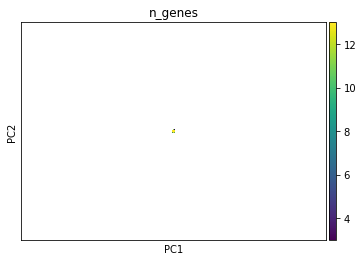

In [95]:
# pca
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='n_genes')

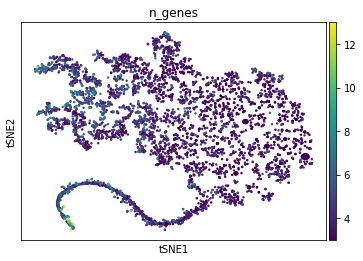

In [16]:
# tsne
ts_adata = sc.tl.tsne(adata)
sc.pl.tsne(adata, color = 'n_genes')

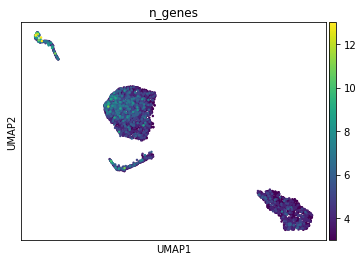

In [17]:
# umap
sc.pp.neighbors(adata, n_neighbors=1000, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color='n_genes')

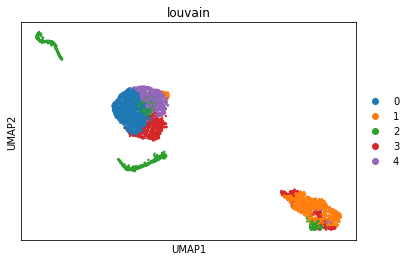

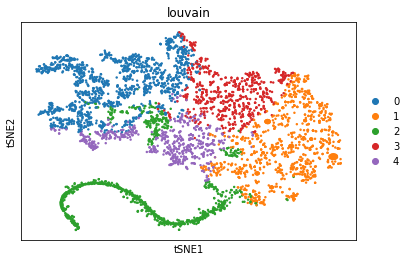

In [18]:
# louvain
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'], use_raw=False)
sc.pl.tsne(adata, color=['louvain'], use_raw=False)
adata.write(results_file)

In [19]:
# Export single fields of the annotation of observations
adata.obs[['n_genes', 'louvain']].to_csv('./write/lin_run.csv')

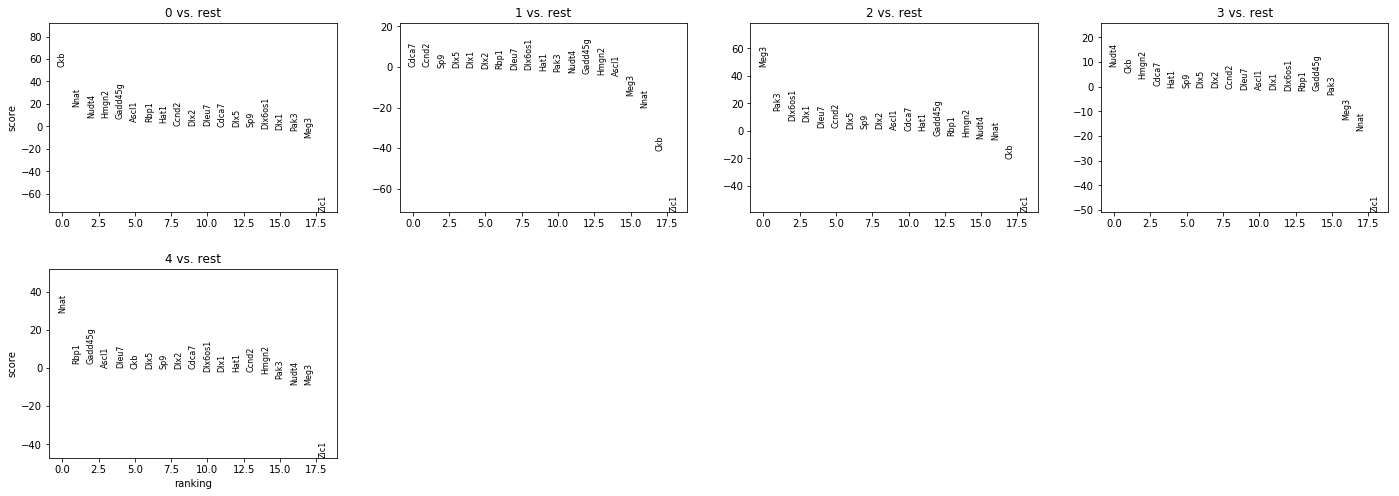

In [20]:
# finding marker genes 
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
adata.write(results_file)

In [ ]:
# 0 
# 1 
# 2: Neurons, OPC 
# 3
# 4

In [ ]:
adata

In [21]:
# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_umap1', 'X_umap2']].to_csv('./write/lin_umapdat.csv')
adata.obsm.to_df()[['X_tsne1', 'X_tsne2']].to_csv('./write/lin_tsnedat.csv')

In [3]:
filename = './write/lin_umapdat.csv'
X = pandas.read_csv(filename)

In [4]:
ids = X.iloc[:,0]
X.index = ids
X_vals = X.values[:, 1:]
print(X_vals)
X.head()

[[-2.32309909e+00  8.32056762e+00]
 [-2.21792842e+00  8.37241385e+00]
 [-2.87125449e+00  8.85330043e+00]
 ...
 [ 4.87108512e+01 -1.56176138e+01]
 [ 1.96503204e+01 -5.10007594e+00]
 [ 2.11987379e+01 -4.69726349e-02]]


,Unnamed: 0,X_umap1,X_umap2
Unnamed: 0,,,
0,0,-2.323099,8.320568
1,1,-2.217928,8.372414
2,2,-2.871254,8.853300
3,3,-2.953768,8.857970
4,4,-2.905045,9.003371


In [5]:
# Using sklearn kmeans
km = KMeans(n_clusters=4)
km = km.fit(X_vals)
y_kmeans = km.predict(X_vals)

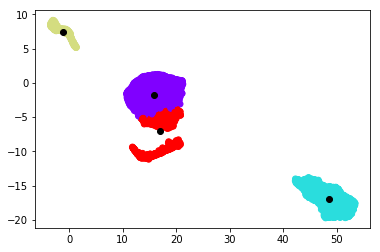

In [6]:
plt.figure
plt.scatter(X_vals[:,0], X_vals[:,1], c=km.labels_, cmap='rainbow')
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:, 1], c='black')
plt.show()

In [7]:
print("writing results to file")
kmeans_filename = 'lin_kmeans_names.txt'
X_kmeans = np.column_stack((X_vals, y_kmeans))
np.savetxt(kmeans_filename, X_kmeans, delimiter="\t", fmt='%s')

writing results to file


In [8]:
df = pandas.read_csv('lin_kmeans_names.txt', sep='\s+', header=None)
df.head()

,0,1,2
0,-2.323099,8.320568,2.0
1,-2.217928,8.372414,2.0
2,-2.871254,8.853300,2.0
3,-2.953768,8.857970,2.0
4,-2.905045,9.003371,2.0


In [9]:
X = df.iloc[:, 0:2]
y = df.iloc[:, 2]

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from statistics import mean

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [13]:
scores = {}
scores_list = []
for k in range(1,25):  
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    knn_pred = neigh.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, knn_pred)
    scores_list.append(scores[k])
print(mean(scores_list))

cv_results = cross_validate(neigh, X, y, cv=10, return_train_score=True)
sorted(cv_results.keys())
print(mean(cv_results['test_score']))

0.9952404809619239
0.9937810850029272


# AdaBoost Classifier

In [14]:
from sklearn.model_selection import cross_validate

In [15]:
# try for different number of trees and learning rates 
from sklearn.ensemble import AdaBoostClassifier

ada_class = AdaBoostClassifier(n_estimators=100, learning_rate=0.01)
model = ada_class.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
ada_results = cross_validate(ada_class, X, y, cv=10, return_train_score=True)

0.9098196392785571


In [16]:
sorted(ada_results.keys())
print(mean(ada_results['test_score']))

0.922587526572976


In [17]:
# try for different number of trees and learning rates 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50)
model = rf.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
cv_results = cross_validate(rf, X, y, cv=10, return_train_score=True)
sorted(cv_results.keys())
print(mean(cv_results['test_score']))

0.9979959919839679
0.9973943662326539


In [18]:
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import classification_report,confusion_matrix
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
print(confusion_matrix(y_test,mlp_pred))
print(classification_report(y_test,mlp_pred))
cv_results = cross_validate(mlp, X, y, cv=10, return_train_score=True)
sorted(cv_results.keys())
print(mean(cv_results['test_score']))

[[219   0   0   1]
 [  0 138   0   0]
 [  0   0  31   0]
 [  0   0   0 110]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       220
         1.0       1.00      1.00      1.00       138
         2.0       1.00      1.00      1.00        31
         3.0       0.99      1.00      1.00       110

   micro avg       1.00      1.00      1.00       499
   macro avg       1.00      1.00      1.00       499
weighted avg       1.00      1.00      1.00       499

0.991765403686259


In [19]:
from sklearn.multiclass import OneVsRestClassifier

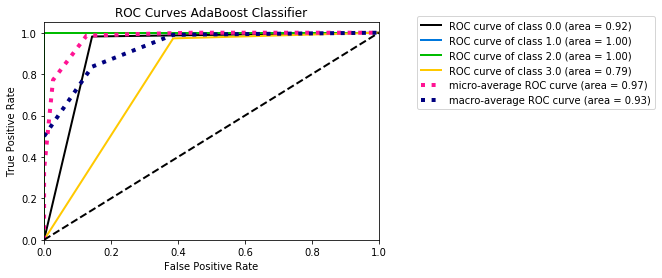

In [29]:
clf = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, learning_rate=0.0001))
y_score = clf.fit(X_train, y_train).decision_function(X_test) 

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves AdaBoost Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

/Users/michellevoong/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


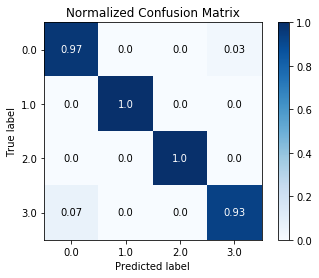

In [30]:
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(clf, X, y)

skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)

In [71]:
cv_results = cross_validate(rf, X, y, cv=10, return_train_score=True)
sorted(cv_results.keys())
print(mean(cv_results['test_score']))

[2. 2. 2. ... 0. 3. 3.]


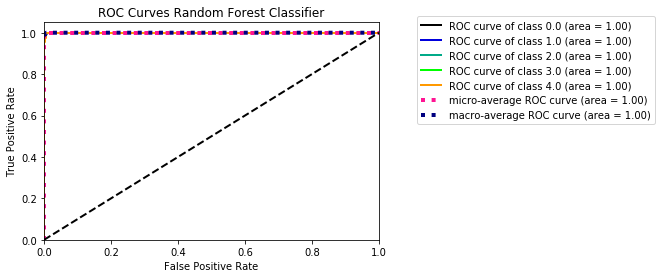

In [56]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200))
y_score = clf.fit(X_train, y_train).predict_proba(X_test) 

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves Random Forest Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

/Users/michellevoong/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


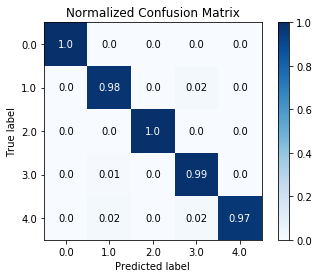

In [60]:
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(clf, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)

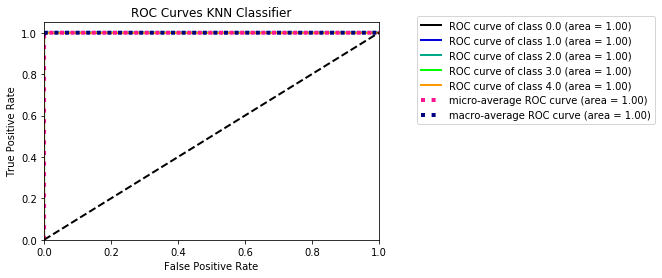

In [57]:
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=25))
y_score = clf.fit(X_train, y_train).predict_proba(X_test) 

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves KNN Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

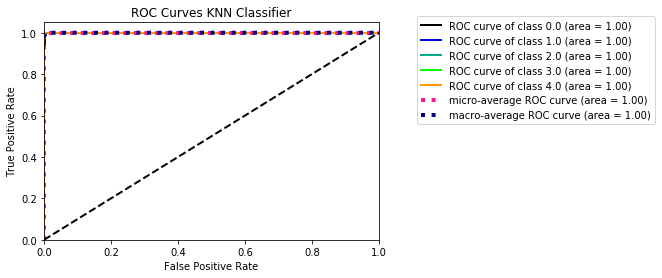

In [58]:
clf = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(30,30,30)))
y_score = clf.fit(X_train, y_train).predict_proba(X_test) 

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves KNN Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()